In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import pickle
import tifffile
import sys
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval


In [2]:
WORKDIR='/home/daniel/gdrive/EPFL/2019-2020/MachineLearning/Project/gravitational_lens_ml'
SRC = os.path.join(WORKDIR, 'src')
DATA = os.path.join(WORKDIR,'data')
RESULTS = os.path.join(WORKDIR, 'results')
TRAIN = os.path.join(DATA, 'datapack2.0train/Public')
TEST = os.path.join(DATA, 'datapack2.0test/Public')
TRAIN_MULTIBAND = os.path.join(DATA, 'train_multiband')
TRAIN_MULTIBAND_AUGMENT = os.path.join(DATA, 'train_multiband_augment')
TEST_MULTIBAND = os.path.join(DATA, 'test_multiband')

In [3]:
image_catalog = pd.read_csv(os.path.join(DATA, 'catalog/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [4]:
band = 'EUC_VIS'
def get_file_id(filename, delimiters = '_|\.|-'):
    id_ = [int(s) for s in re.split(delimiters, filename) if s.isdigit()][0]
    return id_
file_id_train = np.array([get_file_id(f) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
file_id_test = np.array([get_file_id(f) for f in os.listdir(os.path.join(TEST, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
missing_img =  np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False)
print(file_id_train.shape)
print(missing_img)

(99991,)
[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [5]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [6]:
image_catalog['img_exists'] = True
image_catalog['img_exists'].loc[image_catalog['ID'].isin(missing_img)] = False

/home/daniel/anaconda3/envs/gravitational_lens_ml/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
image_catalog = image_catalog.drop_duplicates('ID')
image_catalog[['ID',
               'is_lens']][image_catalog['img_exists']].to_csv(os.path.join(
                   RESULTS, 'lens_id_labels.csv'),
                                                               index=False)

In [8]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

In [9]:
def get_image_filename_from_id(id_, band, set_ = TRAIN, ext = 'fits'):
    fname = os.path.join(set_, '{0}/image{0}-{1}.{2}'.format(band, id_, ext))
    return fname
def plot_all_bands_from_id(id_):
    fig = plt.figure(figsize=(20, 6))
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(aplpy.FITSFigure(data[i], figure=fig, subplot=(1,4,i+1)))
        fitsfigs[i].show_colorscale()
        fitsfigs[i].set_theme('preety')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()
    fig.tight_layout() 
with fits.open(get_image_filename_from_id(290000, 'EUC_VIS')) as hdu1:
    with fits.open(get_image_filename_from_id(290000, 'EUC_H')) as hdu2:
        data1 = hdu1[0].data
        data2 = hdu2[0].data
        data2_reprojected, data2_footprint = reproject_interp(hdu2[0], hdu1[0].header)


INFO: Auto-setting vmin to -2.755e-12 [aplpy.core]
INFO: Auto-setting vmax to  1.357e-11 [aplpy.core]
INFO: Auto-setting vmin to -1.236e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.096e-09 [aplpy.core]
INFO: Auto-setting vmin to -8.179e-11 [aplpy.core]
INFO: Auto-setting vmax to  6.074e-10 [aplpy.core]
INFO: Auto-setting vmin to -1.043e-10 [aplpy.core]
INFO: Auto-setting vmax to  8.215e-10 [aplpy.core]


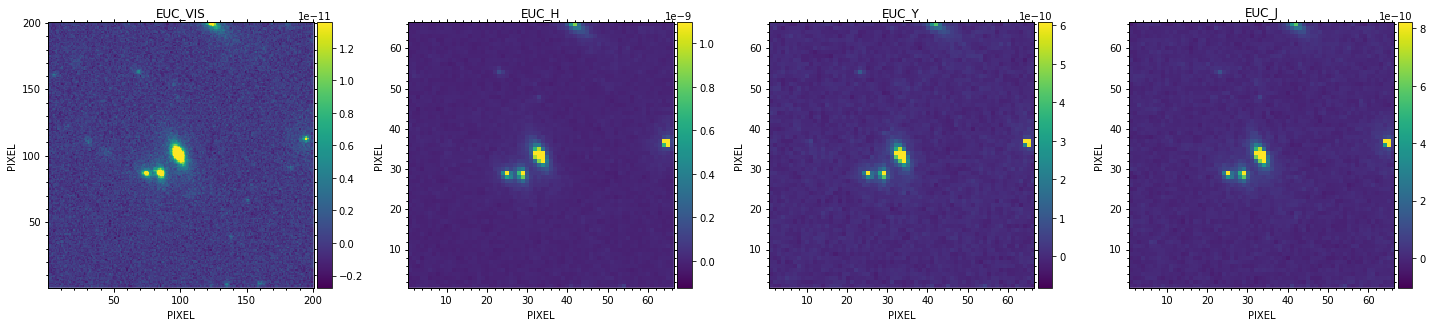

In [10]:
plot_all_bands_from_id(270610)

# Combine bands into `tiff` and test

In [11]:
def build_image(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        interval = AsymmetricPercentileInterval(0, 100, n_samples=100000)
        vmin, vmax = interval.get_limits(band_data)
        stretch = LogStretch() + MinMaxInterval()
        data[:,:,i] = stretch(((np.clip(band_data, vmin*(1), vmax))/(vmax)))
    for t in tables:
        t.close()
    return data.astype(np.float32)


640128
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
2033    True
Name: is_lens, dtype: bool


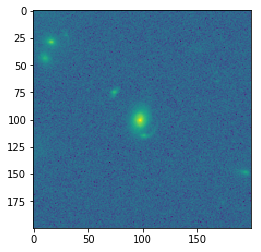

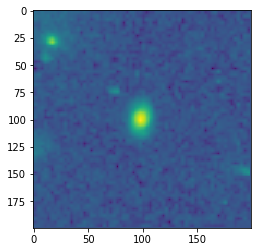

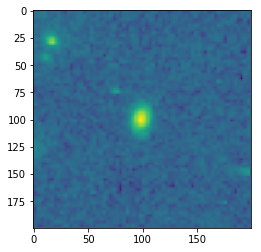

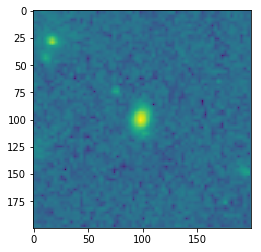

In [12]:
img = build_image(270210, TRAIN)
print(sys.getsizeof(img))
for i in range(4):
    plt.figure()
    print(np.min(img[:,:,i]), np.max(img[:,:,i]))
    a = plt.imshow((img[:,:,i]))
print(image_catalog.loc[image_catalog['ID']==270210]['is_lens'])

# Compare preprocessing with Log + Norm

In [13]:
def build_image_noprocess(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        norm =  LogStretch() + MinMaxInterval()
        data[:,:,i] = norm(band_data)
    for t in tables:
        t.close()
    return data.astype(np.float32)


In [14]:
test_id = 270210
img = build_image(test_id, TRAIN)
img_nopr = build_image_noprocess(test_id, TRAIN)
def plot_slice(image, slice_ratio, axis=0):
    '''Plot a single slice of a picture.
    
    image: Image to plot.
    slice_ratio: float from 0 to 1 where 0 is the top slice, and 1 is the last slice.
    axis: 0 or 1 to show horizontal or vertical slices'''
    
    index = int(image.shape[axis] * slice_ratio)
    slice_ = image[index]
    plt.plot(slice_)


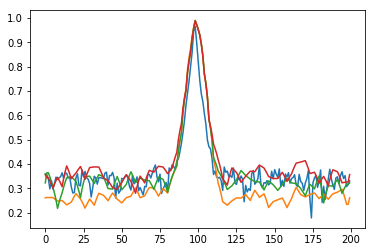

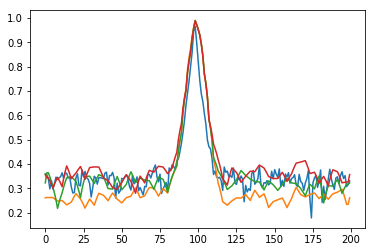

In [15]:
plot_slice(img, 0.5)
plt.figure()
plot_slice(img_nopr, 0.5)

In [16]:
def plot_slice_stack(image, axis=0):
    '''Plot a single slice of a picture.
    
    image: Image to plot.'''
    
    slice_ = np.sum(image, axis=axis)
    print(slice_.shape)
    plt.plot(slice_)

(200, 4)
(200, 4)


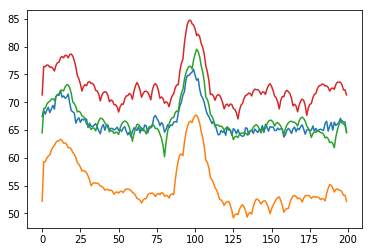

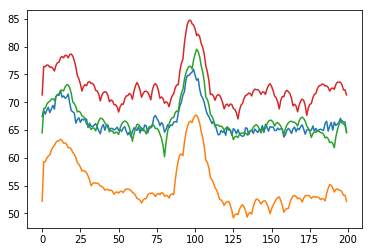

In [17]:
axis = 0
plot_slice_stack(img, axis = axis)
plt.figure()
plot_slice_stack(img_nopr, axis = axis)

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)


Num GPUs Available:  0


# PCA

In [19]:
img = tifffile.imread(DATA+'/train_multiband/image_299896_multiband.tiff')
def flatten_by_channel(original_image):
    """preprocess the image."""
    n_channels = original_image.shape[-1]
    processed_image = original_image.reshape(-1,n_channels)
    return processed_image.astype(np.float32) #Overflow if using unsigned int
flat_img = flatten_by_channel(img)


In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = PCA(whiten=False)
std_flat_img = scaler.fit_transform(flat_img)
pca.fit(std_flat_img)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 4 artists>

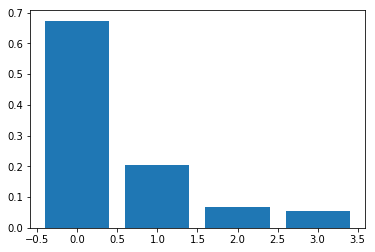

In [21]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [22]:
pca_flat_img = pca.fit_transform(std_flat_img)
pca_image = pca_flat_img.reshape((img.shape[0], img.shape[1], -1))

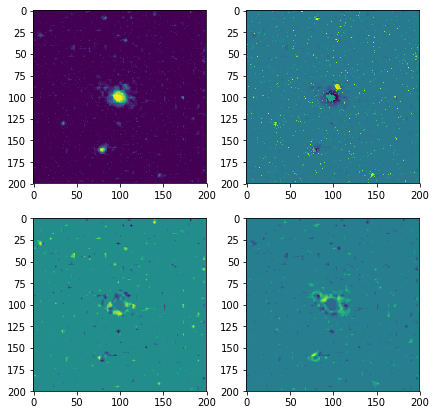

In [23]:
f, ax = plt.subplots(2, 2, figsize = (7, 7))
for i, a in enumerate(ax.ravel()):
    a.imshow(pca_image[:,:,i])

## Covariance Matrix between colors
See, that it is almost diagonal. Not surprising that PC's are almost the same as the priginal colors.

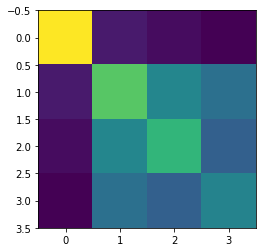

In [24]:
plt.imshow(np.cov(flat_img.T))

# Test  CNN

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, Iterator
from sklearn.model_selection import train_test_split

In [26]:
# From Tensorflow examples
batch_size = 24
epochs = 15
IMG_HEIGHT = 200
IMG_WIDTH = 200


In [37]:
lens_df = pd.read_csv(os.path.join(RESULTS, 'lens_id_labels.csv'), index_col=0)
n_total_clean = len(lens_df)
n_lens_clean = len(lens_df[lens_df['is_lens'] == True])
n_nolens_clean = len(lens_df[lens_df['is_lens'] == False])
equal_class_coeff = n_lens_clean/n_nolens_clean
natural_class_coeff = 1e3*n_lens_clean/n_nolens_clean
print('Original number of data points: %i' % n_total_clean)
print('Original number of lenses: %i' % n_lens_clean)
print('Original number of non-lenses: %i' % n_nolens_clean)
print('Class 0 (non-lens) should be weighted by a coefficient %.2f to simulate equal number of data points in each class'%(equal_class_coeff))
print('Class 0 (non-lens) should be weighted by a coefficient %.2f to simulate natural (1000x more non-lenses) number of data points in each class'%(natural_class_coeff))


def build_generator_dataframe(id_label_df, directory=TRAIN_MULTIBAND):
    files = os.listdir(directory)
    ids = [get_file_id(filename) for filename in files]
    df = pd.DataFrame()
    df['filenames'] = [
        os.path.realpath(os.path.join(directory, f)) for f in files
    ]
    df['labels'] = id_label_df.loc[ids, 'is_lens'].values.astype(int)
    df['ID'] = ids
    return df


dataframe_for_generator = build_generator_dataframe(lens_df, TRAIN_MULTIBAND)
# Append the extra non-lens images:
nolens_extra = list(
    map(lambda f: os.path.realpath(os.path.join(TRAIN_MULTIBAND_AUGMENT, f)),
        os.listdir(TRAIN_MULTIBAND_AUGMENT)))
nolens_extra_df = pd.DataFrame(
    dict(
        zip(['filenames', 'labels', 'ID'], [
            nolens_extra,
            np.zeros(len(nolens_extra), dtype=int),
            9999 * np.ones(len(nolens_extra), dtype=int)
        ])))
dataframe_for_generator = pd.concat([dataframe_for_generator,
                                     nolens_extra_df]).sample(frac=1)
display(dataframe_for_generator.head())

train_df, val_df = train_test_split(dataframe_for_generator,
                                    test_size=0.1,
                                    random_state=42)
total_train = len(train_df)
total_val = len(val_df)
print('Augmented number of data points: %i' % len(dataframe_for_generator))

Original number of data points: 99991
Original number of lenses: 89987
Original number of non-lenses: 10004
Class 0 (non-lens) should be weighted by a coefficient 9.00 to simulate equal number of data points in each class
Class 0 (non-lens) should be weighted by a coefficient 8995.10 to simulate natural (1000x more non-lenses) number of data points in each class
Augmented number of data points: 24753


,filenames,labels,ID
5445,/home/daniel/scratch/gravitational_lens_ml/dat...,1,296877
6171,/home/daniel/scratch/gravitational_lens_ml/dat...,0,9999
3074,/home/daniel/scratch/gravitational_lens_ml/dat...,1,290747
2811,/home/daniel/scratch/gravitational_lens_ml/dat...,0,9999
8800,/home/daniel/scratch/gravitational_lens_ml/dat...,1,299540


In [34]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,4)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


In [ ]:
class TiffImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super(TiffImageDataGenerator, self).__init__(*args, **kwargs)
    def get_input(self, path):
        img = tifffile.imread(path)
        return img
    def image_generator_dataframe(self,dataframe,
                              directory='',
                              x_col='filename',
                              y_col='class',
                              batch_size=64,
                              validation=False, bands = [True, True, True, True]):
        files = dataframe[x_col].values
        while True:
            # Select files (paths/indices) for the batch
            batch_paths = np.random.choice(a=files, size=batch_size)
            batch_input = []
            batch_output = []

            # Read in each input, perform preprocessing and get labels
            for input_path in batch_paths:
                input = self.get_input(os.path.join(directory, input_path))[:,:,bands]
                output = dataframe[dataframe[x_col] == input_path][y_col].values[0]
                if self.preprocessing_function:
                    input = self.preprocessing_function(input)
                if not validation:
                    input = self.random_transform(input)
                batch_input += [input]
                batch_output += [output]
            # Return a tuple of (input,output) to feed the network
            batch_x = np.array(batch_input)
            batch_y = np.array(batch_output)

            yield (batch_x, batch_y)
    

In [35]:
image_data_gen_train = TiffImageDataGenerator(featurewise_center=False,
                                          samplewise_center=False,
                                          featurewise_std_normalization=False,
                                          samplewise_std_normalization=False,
                                          zca_whitening=False,
                                          zca_epsilon=1e-06,
                                          rotation_range=10,
                                          width_shift_range=0.0,
                                          height_shift_range=0.0,
                                          brightness_range=(0.8, 1.1),
                                          shear_range=0.0,
                                          zoom_range=(0.9, 1.1),
                                          channel_shift_range=0.0,
                                          fill_mode='wrap',
                                          cval=0.0,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rescale=None,
                                          preprocessing_function=None,
                                          data_format='channels_last',
                                          dtype='float32')
image_data_gen_val = TiffImageDataGenerator(dtype='float32')

NameError: name 'TiffImageDataGenerator' is not defined

In [0]:
train_data_gen = image_data_gen_train.image_generator_dataframe(train_df,
                                  directory='',
                                  x_col='filenames',
                                 y_col='labels', batch_size = 1, validation=False, bands = [True, False, False, False])
val_data_gen = image_data_gen_val.image_generator_dataframe(train_df,
                                  directory='',
                                  x_col='filenames',
                                 y_col='labels', batch_size = 1, validation=True)
fig, ax = plt.subplots(1,6, figsize = (15, 2.5))
for a in ax.ravel():
    img, label = next(train_data_gen)
    print(img.shape)
    a.imshow(img[0][:,:,0])
    a.set_xlabel(label[0])


# Augment non-lens sample


In [48]:
no_lens_df = dataframe_for_generator[dataframe_for_generator['labels'] == 0]
display(no_lens_df.head())
print('Non-lens original sample size: %s'%len(no_lens_df))
print('Total original sample size: %s'%len(lens_df))

,filenames,labels,ID
2716,/home/daniel/scratch/gravitational_lens_ml/dat...,0,9999
6077,/home/daniel/scratch/gravitational_lens_ml/dat...,0,9999
164,/home/daniel/scratch/gravitational_lens_ml/dat...,0,9999
1162,/home/daniel/scratch/gravitational_lens_ml/dat...,0,9999
11600,/home/daniel/scratch/gravitational_lens_ml/dat...,0,9999


Non-lens original sample size: 14739
Total original sample size: 99991


In [38]:
augment_nolens = TiffImageDataGenerator(featurewise_center=False,
                                          samplewise_center=False,
                                          featurewise_std_normalization=False,
                                          samplewise_std_normalization=False,
                                          zca_whitening=False,
                                          zca_epsilon=1e-06,
                                          rotation_range=20,
                                          width_shift_range=0.0,
                                          height_shift_range=0.0,
                                          brightness_range=(0.8, 1.1),
                                          shear_range=0.0,
                                          zoom_range=(0.9, 1),
                                          channel_shift_range=0.0,
                                          fill_mode='wrap',
                                          cval=0.0,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rescale=None,
                                          preprocessing_function=None,
                                          data_format='channels_last',
                                          dtype='float32')
augment_nolens_gen = augment_nolens.image_generator_dataframe(no_lens_df,
                                  directory='',
                                  x_col='filenames',
                                 y_col='labels', batch_size = 1, validation=False)


NameError: name 'TiffImageDataGenerator' is not defined

In [39]:
i = 8
fig, ax = plt.subplots(1,i, figsize = (2.5*i, 2.5))
for a in ax.ravel():
    img, label = next(augment_nolens_gen)
    a.imshow(img[0][:,:,3])
    a.set_xlabel(label[0])
plt.tight_layout()

NameError: name 'augment_nolens_gen' is not defined

# Load saved model

In [46]:
new_model = tf.keras.models.load_model(os.path.join(RESULTS, 'simple_cnn.h5'))

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      592       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0

In [41]:
loss, acc = new_model.evaluate_generator(val_data_gen, steps = 1000, use_multiprocessing=True, verbose  = 1)

NameError: name 'val_data_gen' is not defined

In [0]:
predictions = new_model.predict_generator(augment_nolens_gen, steps = 10)
print(predictions)

In [43]:
next(augment_nolens_gen)[0].shape

NameError: name 'augment_nolens_gen' is not defined

In [44]:
random_prediction = new_model.predict(np.random.random(200*200*4).reshape(200, 200, 4)[None, :, :, :])
print('The prediction on random noise is: %.2f'%random_prediction)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

# Check History of model training

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(range(len(history['loss'])),
           history['val_loss'],
           label='Validation loss',
           marker='o',
           c='b')
ax1.plot(range(len(history['loss'])),
           history['loss'],
           label='Training loss',
           marker='o',
           c='r')
ax2.plot(range(len(history['loss'])),
           history['val_accuracy'],
           label='Validation accuracy',
           marker='o',
           c='b',
           ls='--',
           fillstyle='none')
ax2.plot(range(len(history['loss'])),
           history['accuracy'],
           label='Training accuracy',
           marker='o',
           c='r',
           ls='--',
           fillstyle='none')
ax1.set_xlabel('Epoch')
ax1.legend(loc=(-0.1,1))
ax2.legend(loc=(0.9,1))
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.gcf()
plt.savefig(os,path,join(RESULTS, 'plots/simple_cnn.png'), dpi = 200)

NameError: name 'history' is not defined